In [ ]:
Dockerfile 构建镜像进阶

In [ ]:
Docker 在镜像的设计中，引入了层（layer）的概念。也就是说，用户制作镜像的每一步操作，都会生成一个层，也就是一个增量rootfs。

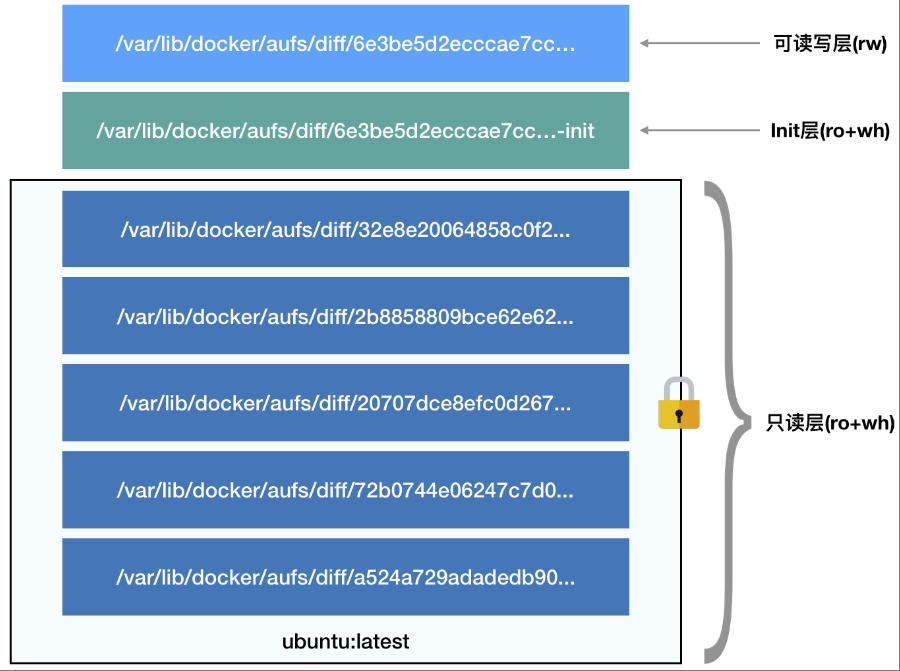

In [1]:
from IPython.display import Image
Image(filename="./dockerfile_layers.jpg",width=400,height=400)

In [ ]:
第一部分：只读层。
    它是这个容器的 rootfs 最下面的五层，对应的正是 ubuntu:latest 镜像的五层。
    可以看到，它们的挂载方式都是只读的（ro+wh，即 readonly+whiteout）。
第二部分：可读写层。
    它是这个容器的 rootfs 最上面的一层,它的挂载方式为：rw，即 read write。在没有写入文件之前，这个目录是空的。
    而一旦在容器里做了写操作，修改产生的内容就会以增量的方式出现在这个层中。这个可读写层的作用，就是专门用来存放你修改 rootfs 后产生的增量，
    无论是增、删、改，都发生在这里。而当我们使用完了这个被修改过的容器之后，还可以使用 docker commit 和 push 指令，保存这个被修改过的可读写层，
    并上传到 Docker Hub 上，供其他人使用；而与此同时，原先的只读层里的内容则不会有任何变化。这，就是增量rootfs 的好处。
第三层：Init层
    它是一个以“-init”结尾的层，夹在只读层和读写层之间。
    Init 层是 Docker 项目单独生成的一个内部层，专门用来存放 /etc/hosts、/etc/resolv.conf 等信息。
    需要这样一层的原因是，这些文件本来属于只读的 Ubuntu 镜像的一部分，但是用户往往需要在启动容器时写入一些指定的值比如 hostname，
    所以就需要在可读写层对它们进行修改。可是，这些修改往往只对当前的容器有效，我们并不希望执行 docker commit 时，把这些信息连同可读写层一起提交掉。
    所以，Docker 做法是，在修改了这些文件之后，以一个单独的层挂载了出来。而用户执行 docker commit 只会提交可读写层，所以是不包含这些内容的。

In [ ]:
Dockerfile是一个用来构建镜像的文本文件，因此可以使用Vim或者touch在终端中创建，文本内容包含了一条条构建镜像所需要的指令和操作命令；
每条指令构建一层镜像，因此每一条指令的内容，就是描述该层镜像应当如何构建（即要执行的操作命令）

In [ ]:
1. Docker 指令集

In [ ]:
Dockerfile 指令集：
FROM 这个镜像的妈妈是谁？（指定基础镜像）
MAINTAINER 告诉别人，谁负责养它？（指定维护者信息，可以没有）LABLE key=values
RUN 你想让它干啥（在命令前面加上RUN即可）
ADD/COPY 给它点创业资金（COPY文件，会自动解压）
WORKDIR 我是cd,今天刚化了妆（设置当前工作目录）
VOLUME 给它一个存放行李的地方（设置卷，挂载主机目录）
EXPOSE 它要打开的门是啥（指定对外的端口）
CMD 奔跑吧，兄弟！（指定容器启动后的要干的事情）
ENTRYPOINT  容器启动命名
ENV 环境变量
USER 切换用户

In [ ]:
Docker build 语法
# docker build 指令用于根据给定的 Dockerfile 构建 Docker 镜像

# docker build 语法
docker build [OPTIONS]<PATH|URL->

# 常用选项说明
--build-arg，设置构建时的变量
--no-cache，默认false。设置该选项，将不使用Build Cache构建镜像
--pull，默认false。设置该选项，总是尝试pull镜像的最新版本
--compress，默认false。设置该选项，将使用gzip压缩构建的上下文
--disable-content-trust，默认true。设置该选项，将对镜像进行验证
--file, -f，Dockerfile的完整路径，默认值为‘PATH/Dockerfile’
--isolation，默认--isolation="default"，即Linux命名空间；其他还有process或hyperv
--label，为生成的镜像设置metadata
--squash，默认false。设置该选项，将新构建出的多个层压缩为一个新层，但是将无法在多个镜像之间共享新层；设置该选项，实际上是创建了新image，同时保留原有image。
--tag, -t，镜像的名字及tag，通常name:tag或者name格式；可以在一次构建中为一个镜像设置多个tag
--network，默认default。设置该选项，Set the networking mode for the RUN instructions during build
--quiet, -q ，默认false。设置该选项，Suppress the build output and print image ID on success
--force-rm，默认false。设置该选项，总是删除掉中间环节的容器
--rm，默认--rm=true，即整个构建过程成功后删除中间环节的容器 

# 示例
docker build -t soso/bbauto:v2.1 .

-docker build  是docker创建镜像的命令 
-t 是标识新建的镜像属于 soso的 bbauto镜像 
：v2.1 是tag 
"."是用来指明使用的Dockerfile文件当前目录的（也可以是绝对路径）

2.创建镜像

In [ ]:
2.1 所在的文件夹和 Dockerfile 文件
[root@docker-server ~]# mkdir sinatra
[root@docker-server ~]# cd sinatra/
[root@docker-server sinatra]# touch Dockerfile

2.2 在 Dockerfile 文件中写入指令，每一条指令都会更新镜像信息
[root@docker-server sinatra]# vim Dockerfile
#This is a comment 
FROM daocloud.io/library/centos:7  #基于哪个基础镜像
MAINTAINER soso soso@docker-server  #指定作者（可选）
RUN touch a.txt
RUN mkdir /test
RUN yum -y install vim

In [ ]:
格式说明：指令要大写；注释符“#”；每一个指令后面需要跟空格；FROM 命令是告诉docker 我们的镜像什么从哪里下载。 
MAINTAINER 是描述 镜像的创建人。 
RUN 命令是在镜像内部执行。就是说他后面的命令应该是针对镜像可以运行的命令。 

In [ ]:
2.3 创建镜像
docker build -t soso/centos:7 .

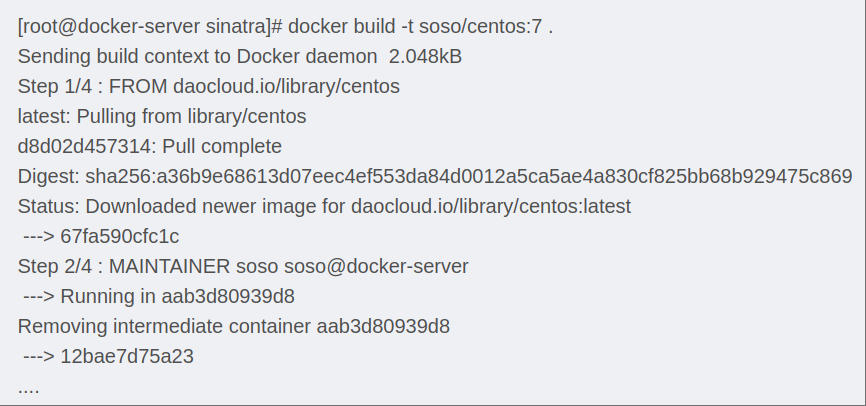

In [2]:
# 详细执行过程
Image(filename="./dockerfile_composing_process.jpg",width=400,height=400)

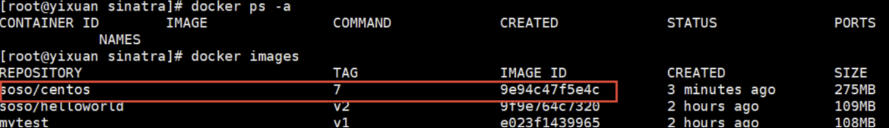

In [4]:
# 2.4 镜像创建完成后，从镜像（class）创建容器（object instance）
Image(filename="./buliding_container.jpg",width=400,height=400)

In [ ]:
3.镜像构建示例

In [ ]:
3.1 单阶段构建镜像
#下载基础镜像
docker pull nginx
#编写Dockerfile
vim Dockerfile
FROM nginx
CMD ["nginx","-g","daemon off;"]
#构建镜像
docker build -t nginx:v1.1 .
#运行容器
docker run -itd --name nginx -p 80:80 nginx:v1.1
#查看容器
docker ps

In [ ]:
3.2 以 niginx:v1.1 作为builder
FROM centos
RUN mkdir /test
COPY --from=builder /etc/nginx/nginx.conf /test
#构建镜像
docker build -t centos:v1.2 .
#查看镜像
docker images
#容器验证，centos中的文件 nginx.conf 是否从/etc/nginx/拷贝到/test

In [ ]:
3.3 创建 jenkins 的 Dockerfile
# 做实验之前，必须得把宿主机的ipv4路由转发功能打开（如果遇到容器访问不到的情况）
echo "net.ipv4.ip_forward=1" >> /etc/sysctl.conf
sysctl -p

# 创建 dockerfile 的根目录 tomcat
[root@docker-server ~]# mkdir tomcat 
[root@docker-server ~]# cd tomcat/

# 将以下安装包拷贝至tomcat目录中
[root@docker-server1 tomcat]# ls
apache-tomcat-8.5.47.tar.gz  Dockerfile  jdk-8u211-linux-x64.tar.gz  jenkins.war

# 编辑 Dockerfirle
[root@docker-server tomcat]# touch Dockerfile
[root@docker-server tomcat]# vim Dockerfile

# vim 编写文件
FROM centos:7
MAINTAINER docker-server
ENV JAVA_HOME /usr/local/jdk1.8.0_211
ENV TOMCAT_HOME /usr/local/apache-tomcat-8.5.47
ENV PATH=$JAVA_HOME/bin:$PATH
ADD apache-tomcat-8.5.47.tar.gz /usr/local/  
ADD jdk-8u211-linux-x64.tar.gz /usr/local/
RUN rm -rf /usr/local/apache-tomcat-8.5.47/webapps/*
ADD jenkins.war /usr/local/apache-tomcat-8.5.47/webapps
RUN rm -rf apache-tomcat-8.5.47.tar.gz  jdk-8u211-linux-x64.tar.gz
EXPOSE 8080
ENTRYPOINT ["/usr/local/apache-tomcat-8.5.47/bin/catalina.sh","run"]  #运行命令

[root@docker-server tomcat]# pwd
/root/tomcat

[root@docker-server tomcat]# ls  #将jdk与tomcat还有jenkins的包上传到tomcat目录中
apache-tomcat-8.5.47.tar.gz  Dockerfile  jdk-8u211-linux-x64.tar.gz  jenkins.war
[root@docker-server tomcat]# docker build -t jenkins:v1 .
[root@docker-server tomcat]# docker run -itd --name jenkins1 -p 8081:8080 jenkins:v1

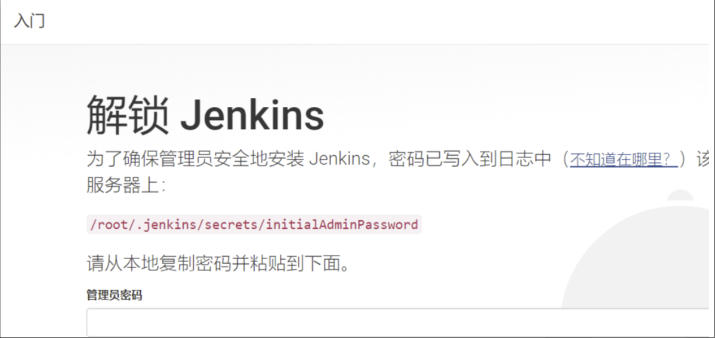

In [5]:
# 运行结果
Image(filename="./3.3.jpg",width=400,height=400)

In [ ]:
3.4 创建 nginx 的dockerfile

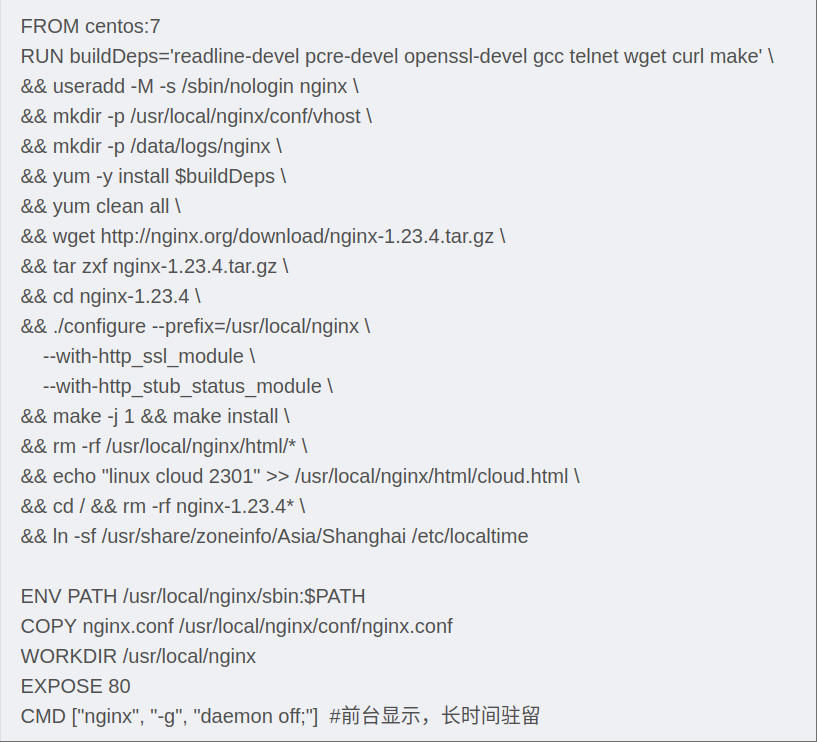

In [7]:
# dockerfile 的内容
Image(filename="Nginx_dockerfile.jpg",width=500,height=600)

In [ ]:
# dockerfile 文件解析
这个 Dockerfile 用于构建一个基于 CentOS 7 的镜像，并在其中安装和配置 Nginx。以下是每一层的作用描述：

1. FROM centos:7 指定基础镜像为CentOS7。Dockerfile的起点，后续所有操作都基于CentOS7镜像进行。
2. RUN buildDeps 定义一个变量 `buildDeps`，列出构建 Nginx 所需的依赖包。
    包括开发工具和库（如 `gcc`、`pcre-devel` 等），用于编译和安装 Nginx。
3. RUN useradd -M -s /sbin/nologin nginx 
    创建一个名为 `nginx` 的用户。
     - `-M`: 不创建用户的主目录。
     - `-s /sbin/nologin`: 指定用户的登录 shell 为 `/sbin/nologin`，防止用户登录系统。
     - 这个用户将用于运行 Nginx 服务。
4. RUN mkdir -p /usr/local/nginx/conf/vhost`**
   - 创建目录 `/usr/local/nginx/conf/vhost`。用于存放 Nginx 的虚拟主机配置文件。
5. RUN mkdir -p /data/logs/nginx
   - 创建目录 `/data/logs/nginx`。用于存放 Nginx 的日志文件。
6. RUN yum -y install $buildDeps
   - 安装之前定义的依赖包。使用 `yum` 安装所有构建 Nginx 所需的依赖。
7. RUN yum clean all
   - 清理 yum 缓存。删除安装包和依赖信息，减小镜像体积。
8. RUN wget http://nginx.org/download/nginx-1.23.4.tar.gz
   - 从 Nginx 官方网站下载指定版本的源码包。
9. RUN tar zxf nginx-1.23.4.tar.gz`**
   - 使用 `tar` 解压下载的 Nginx 源码包，为后续编译做准备。
10. RUN cd nginx-1.23.4
    - 进入解压后的源码目录，准备编译。
11. RUN ./configure --prefix=/usr/local/nginx --with-http_ssl_module --with-http_stub_status_module`**
    - **作用**: 配置 Nginx 编译选项。
    - **描述**: 
      - `--prefix=/usr/local/nginx`: 指定 Nginx 安装路径。
      - `--with-http_ssl_module`: 启用 HTTPS 支持。
      - `--with-http_stub_status_module`: 启用状态监控模块。
12. RUN make -j 1 && make install
    - 编译并安装 Nginx。
    - **描述**: 
      - `make -j 1`: 使用单线程编译。
      - `make install`: 安装 Nginx 到指定路径。
13. RUN rm -rf /usr/local/nginx/html/*
    - 清空 Nginx 默认的 HTML 文件。
14. RUN echo "linux cloud 2301" >> /usr/local/nginx/html/cloud.html
    - 在 /usr/local/nginx/html/ 目录下创建 cloud.html 文件，并写入内容 `linux cloud 2301`。
15. RUN cd / && rm -rf nginx-1.23.4*
    - 清理 Nginx 源码和编译文件。删除解压后的源码目录和相关文件，减小镜像体积。
16. RUN ln -sf /usr/share/zoneinfo/Asia/Shanghai /etc/localtime
    - 创建符号链接，将系统时区设置为亚洲/上海。
17. ENV PATH /usr/local/nginx/sbin:$PATH
    - 设置环境变量 `PATH`。将 Nginx 的可执行文件路径添加到系统环境变量中，方便直接运行 Nginx。
18. COPY nginx.conf /usr/local/nginx/conf/nginx.conf
    - 将本地的 `nginx.conf` 文件复制到镜像中的 `/usr/local/nginx/conf/` 目录。
19. WORKDIR /usr/local/nginx
    - 设置工作目录，将后续操作的工作目录设置为 `/usr/local/nginx`。
20. EXPOSE 80
    - 声明容器监听的端口，告诉 Docker 容器会使用 80 端口（HTTP 默认端口）。
21. CMD ["nginx", "-g", "daemon off;"]
    - **作用**: 指定容器启动时的默认命令。
    - **描述**: 
      - `nginx`: 启动 Nginx 服务。
      - `-g "daemon off;"`: 以前台模式运行 Nginx，防止容器退出。
### 总结
这个 Dockerfile 构建了一个包含 Nginx 的 CentOS 7 镜像，配置了基本的运行环境、时区、虚拟主机目录、日志目录等，
并将 Nginx 设置为默认启动服务。

In [ ]:
# 运行容器
docker run -itd --name nginx1 -p 8082:80 nginx:1.23.4
参数含义：
-itd 是三个参数的缩写形式：-i, -t, 和 -d。
-i (interactive):该选项告诉 Docker 容器保持标准输入 (stdin) 是激活状态的。
这意味着容器能够接收来自用户终端的输入，例如通过键盘输入命令或数据。
-t (tty):
该选项为容器分配一个伪终端 (pseudo-tty)。虚拟终端是终端设备的软件仿真，它提供了一个类似本地终端的环境，允许用户像使用本地终端一样与容器交互。
-d (detach):该选项让容器在后台运行，并将控制权返回到本地终端。这意味着容器不会在前台运行，而是作为后台进程运行。

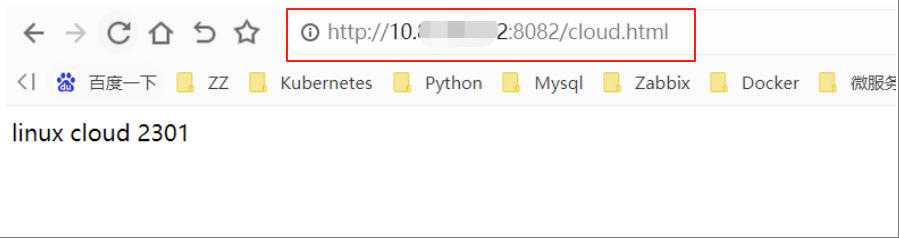

In [8]:
# 运行结果
Image(filename="niginx_image_results.jpg",width=500,height=500)

In [ ]:
3.5 CMD 和 ENTRYPOINT 的区别
如果使用dockerfile时用的是CMD，那么启动容得时候就不需要加解释器了，如果加了解释器，那么CMD就失效了
如果使用dockerfile时用ENTRYPOINT，那么启动容器时加不加解释器就无所谓了，命令都会执行

对于CMD：
每个Dockerfile中只能有一个CMD如果有多个那么只执行最后一个；
CMD 相当于启动docker时候后面添加的参数，比如：
# docker run -itd --name test image(镜像) /bin/bash -c
镜像名称后面跟了一个/bin/bash -c ，其实等价于在dockerfile中的CMD ["/bin/bash","-c"]；
如果dockerfile中的CMD中有了CMD["/bin/bash","-c"],那么就不用在执行的时候再添加了，
如果添加了参数的话那么就相当于要执行你添加的参数，默认的CMD中的参数就无效了。

对于ENTRYPOINT：
Dockerfile中ENTRYPOINT也只能存在一个，若存在多个那么只执行最后一个，理解为开机启动的意思，和CMD有点像，不过还是有区别。
Dockerfile中有ENTRYPOINT ["tail","-f","/var/log/nginx/access.log"]，那么启动的时候镜像就执行了这个里面的内容，
如果像上面带参数的话就相当于在这个执行的内容后面再加入参数。
# docker run -itd --name test image(镜像名) /bin/bash -c
那么对于ENTRYPOINT相当于是：
启动docker的时候执行了：tail -f /var/log/nginx/access.log /bin/bash -c
那就会报错！

In [ ]:
4. Dockerfile 优化

In [ ]:
1.多阶段构建镜像
使用多个FROM指令，将构建过程分为多个阶段；每个阶段（每个FROM）生成一个独立镜像，后续阶段可以使用前面生成的镜像作为基础镜像。
多阶段构建的有是在于能够有效减少最终镜像体积，分离构建环境和运行环境。每个FROM都开始一个新构建阶段。
2.将不需要的命令丢入 /dev/null
如果不需要某些命令的标准输出和错误输出，可以重定向到/dev/null，避免不必要的输出写入镜像层，减少镜像体积。
重定向语法： command > /dev/null 2>&1
3.使用普通用户运行
在Dockerfile中使用USER指令切换到非root用户，以最小权限原则运行应用，提升安全性。确保应用程序有足够权限访问所需资源。
4.选择合适的基础镜像
Alpine Linux 相比ubuntu，centos体积更小，更适合作为基础镜像（需要评估与应用程序的兼容性）
5.减少镜像层数
RUN命令尽量卸载一条里，每次RUN命令都是在之前的镜像进行封装，只增大不减小。
6.清除缓存
每次安装完依赖之后，务必清理缓存和临时文件，以减少镜像体积。
对于centos：yum clear all
对于ubuntu：apt-get clean && rm -rf /var/lib/apt/lists/*
-apt-get clean:清理下载的包文件;-rm -rf /var/lib/apt/lists/* 删除apt包管理器生成的缓存文件

In [ ]:
对于 Ubuntu，使用 apt 包管理工具，而不是 yum,因此依赖包列表和安装为：
RUN apt-get update && apt-get install -y \
    <package1> \
    <package2> \
    --no-install-recommends && \
- --no-install-recommends 用于避免安装不必要的推荐包，进一步减小镜像体积。

In [ ]:
优化后的ubuntu安装：
# Stage 1: Builder (Build Environment)
FROM ubuntu:latest as builder

# Install build tools and dependencies
RUN apt-get update && \
    apt-get install -y --no-install-recommends build-essential libssl-dev && \
    apt-get clean && \
    rm -rf /var/lib/apt/lists/*

# Build application (假设应用是简单的C程序)
WORKDIR /usr/src/app
COPY src/ .
RUN gcc -o app app.c

# Stage 2: Runtime (运行环境)
FROM ubuntu:latest as runtime

# 安装运行时依赖
RUN apt-get update && \
    apt-get install -y --no-install-recommends libssl1.1 && \
    apt-get clean && \
    rm -rf /var/lib/apt/lists/*

# 复制构建阶段的可执行文件
WORKDIR /usr/bin
COPY --from=builder /usr/src/app/app .

# 设置容器启动命令
CMD ["/usr/bin/app"]